In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import tqdm
import pandas as pd
import seaborn as sns

from lib.model import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDatasetAll2All

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
DEVICE = "cpu"

In [5]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True))

<All keys matched successfully>

In [6]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE
    )
)

print("Dataset length:", len(dataset))

Dataset length: 5000


In [7]:
errors = {
    "dt": [],
    "l2_error": [],
    "epsilon": [],
}

In [8]:
BATCH_SIZE = 32
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
fno.eval()
progress_bar = tqdm.tqdm(data_loader)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1)

        for j in range(len(dt)):
            errors["dt"].append(dt[j].item())
            errors["l2_error"].append(loss[j].item())
            errors["epsilon"].append(eps[j].item())

        ood_relative_l2 += loss.sum().item()

    ood_relative_l2 /= len(dataset)

print(rf"OOD relative L2 error: {ood_relative_l2}")

100%|██████████| 157/157 [00:03<00:00, 39.90it/s]

OOD relative L2 error: 0.17029946718215944


In [10]:
df = pd.DataFrame(errors)
# sort by dt
df = df.sort_values(by="dt")
df

,dt,l2_error,epsilon
3200,0.00125,0.085555,0.005
64,0.00125,0.085555,0.005
4016,0.00125,0.085386,0.005
4015,0.00125,0.085555,0.005
4014,0.00125,0.085555,0.005
...,...,...,...
2086,0.20000,0.340197,0.200
848,0.20000,0.340197,0.200
3803,0.20000,0.340197,0.200
3160,0.20000,0.340197,0.200


In [11]:
# calculate mean error for each dt
mean_error = df.groupby(pd.cut(df["dt"], bins=20), observed=True)["l2_error"].mean().reset_index()
mean_error["dt"] = mean_error["dt"].apply(lambda x: f"{x.mid:.3f}")
mean_error

,dt,l2_error
0,0.006,0.105249
1,0.016,0.051552
2,0.026,0.059566
3,0.036,0.134247
4,0.046,0.347872
5,0.056,0.076776
6,0.076,0.202517
7,0.096,0.267672
8,0.116,0.360357
9,0.145,0.362004


<Axes: xlabel='dt', ylabel='l2_error'>

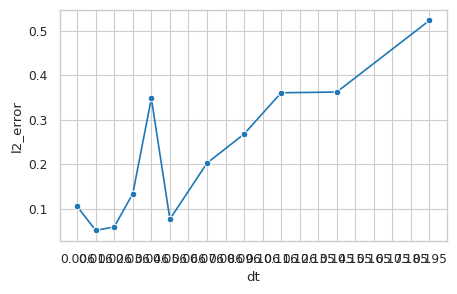

In [12]:
# plot the error
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=mean_error, x="dt", y="l2_error", ax=ax, marker="o")

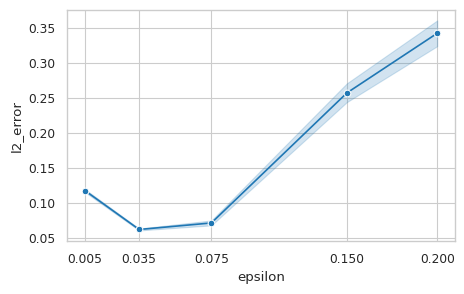

In [13]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=df, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(df["epsilon"].unique())
plt.show()

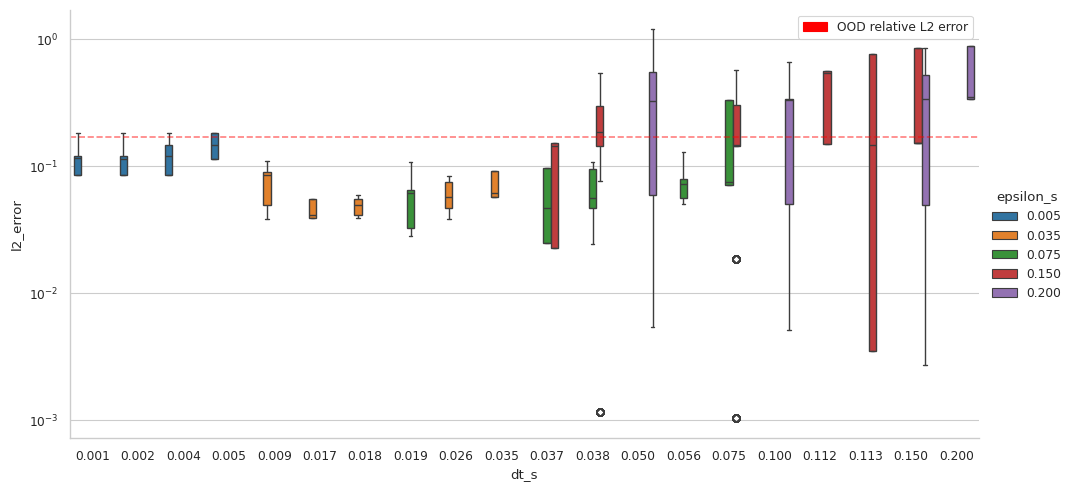

In [14]:
df["epsilon_s"] = df["epsilon"].apply(lambda x: f"{x:.3f}")
df["dt_s"] = df["dt"].apply(lambda x: f"{x:.3f}")

sns.catplot(
    data=df,
    x="dt_s",
    y="l2_error",
    log_scale=True,
    hue="epsilon_s",
    height=5,
    aspect=2,
    kind="box",
)
# draw a horizontal line at the OOD relative L2 error
plt.axhline(y=ood_relative_l2, color="r", linestyle="--", label="OOD relative L2 error", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label="OOD relative L2 error")
    ]
)


In [15]:
BATCH_SIZE = 5
sampler = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

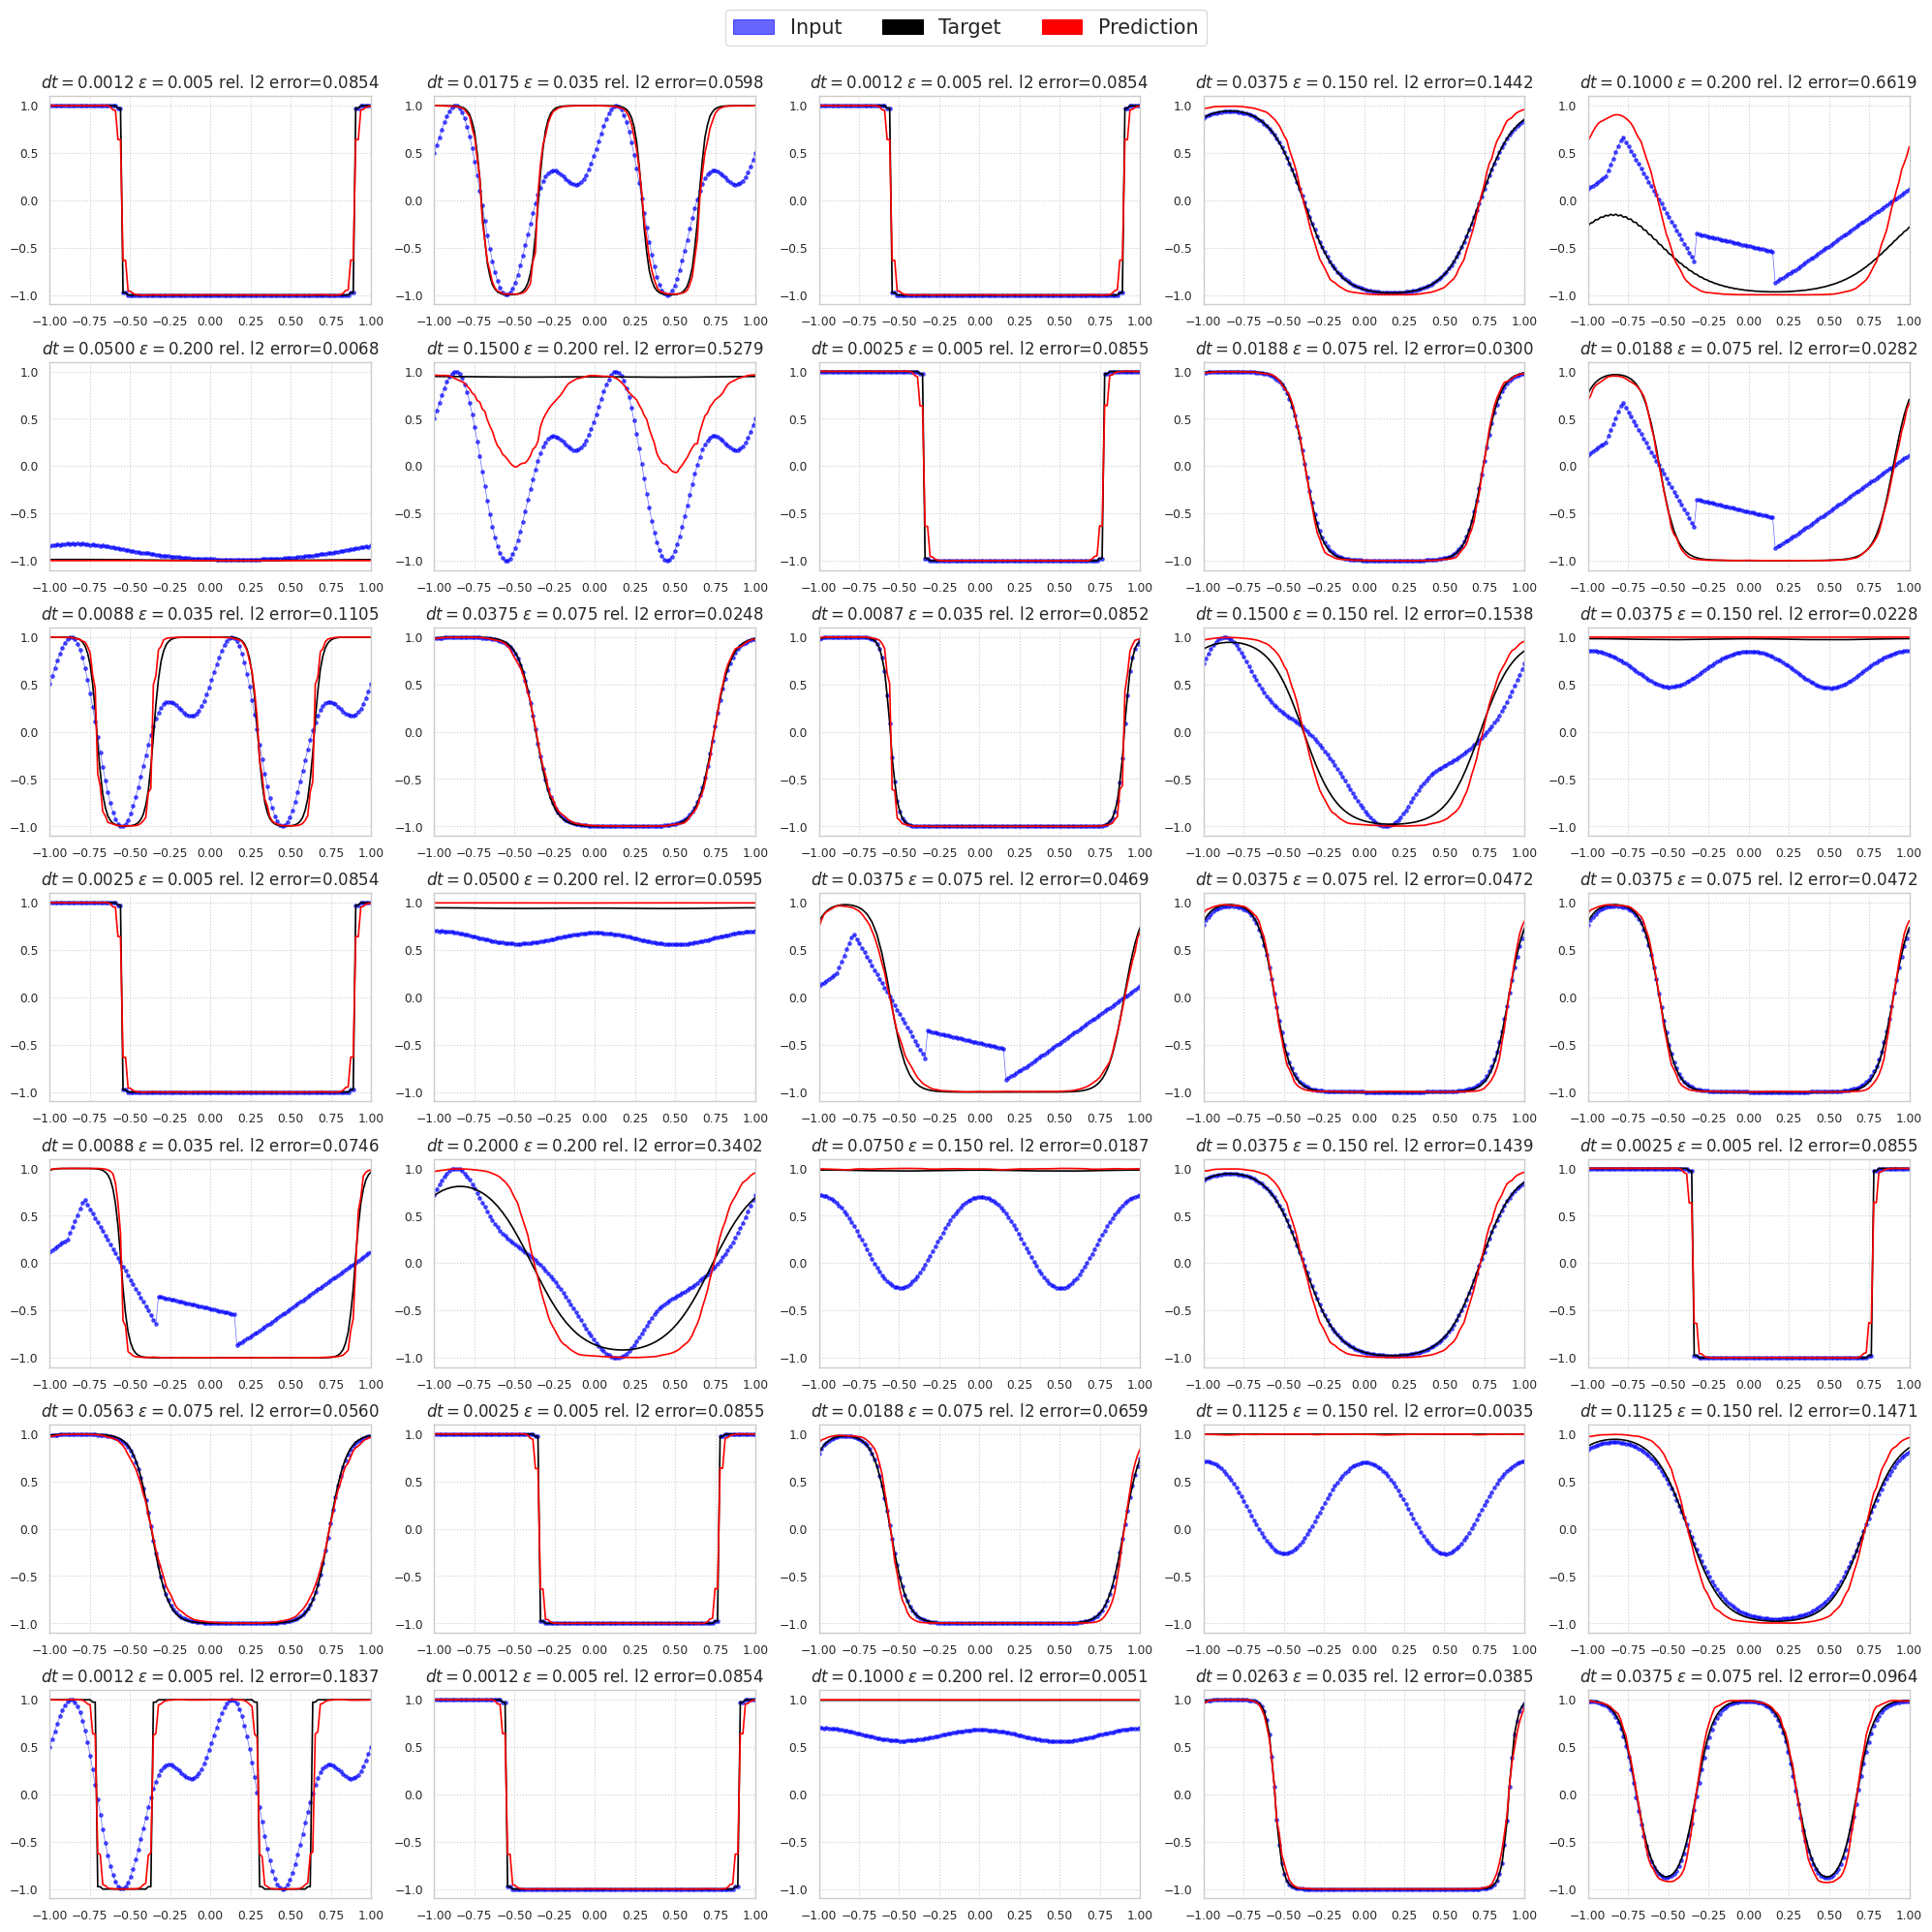

In [16]:
fig, axs = plt.subplots(7, BATCH_SIZE, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = eps[j].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]

        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.plot(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.6,
            linewidth=0.5,
            color="blue",
            marker="."
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = l1 + l2 + l3

labels = [line.get_label() for line in lines]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    colour = lines[group_idx].get_color()
    opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()